# Data Engineering: Image Processing
- Some basic uses of Pillow, Matplotlib, OS, and Re packages.
- Take repo of images, get relevant image data and put into dataframe
- Reorganize, based on image characteristics such as median brightness, the images into folders of equal size grouped by that characteristic.

#### 1. Import Dependencies
- Pillow for image handling
- Numpy/Pandas for array manipulations and dataframes
- Matplotlib for plotting tools
- Os for file manipulation and re for Regex pattern matching

In [1]:
from PIL import Image, ImageStat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil, re

#### 2. Descriptions and IDs
- Use regex to turn file names into a description, id pair
- The code: "^(.*?)-(\d+)\.jpg$" must start with anything until hitting a dash then number. Then must end with .jpg

In [2]:
def get_description_id(file):
    # Get file name that INCLUDES the FULL PATH
    file_name_w_path = file
    # Separate out the base name
    file_name = os.path.basename(file)
    # Separate file name and id
    pattern = re.compile(r'^(.*?)-(\d+)\.jpg$')
    # Return matches of pattern
    match = pattern.match(file_name)

    if match:
        description = match.group(1).replace('-', ' ') # Remove dashes from description
        image_id = match.group(2)
    else:
        description = None
        image_id = None
    
    return file_name_w_path, description, image_id      

#### 3. Get the Numeric Data
- Get height, width, average color, median brightness, and the brighest pixel using numpy

In [3]:
def get_data(img):
    # Get height/width
    width, height = img.size[0], img.size[1]
    
    # Color Average
    color_stats = ImageStat.Stat(img)
    color_avg = color_stats.mean
    
    # Grey scale
    grey_img = img.convert('L')
    grey_stats = ImageStat.Stat(grey_img)
    brightness_median = grey_stats.median[0]
    
    # Brightest pixel row and column
    img_array = np.array(grey_img) # Convert into array
    rows, cols = np.unravel_index(np.argmax(img_array), img_array.shape) # Get the location by making 2D again
    
    return width, height, color_avg, brightness_median, rows, cols
    

#### 4. Get all of the image data together

In [4]:
def get_image_data(file):    
    # Open image
    img = Image.open(file)

    # Description, id
    file_name, description, image_id = get_description_id(file)

    # Other data
    width, height, color_avg, median, row, col = get_data(img)

    return {'file_name': file_name, 'Description': description, 'Image_id': image_id, 
        'width': width, 'height': height,'color_avg': color_avg, 'median_brightness': median, 
        'brightest_pxl_row': row, 'brightest_pxl_col': col}
    
    

#### 5. Put all image data in Dataframe

In [5]:
def get_image_df(folder):
    # List files in folder
    files = os.listdir(folder)
    files_w_paths = [os.path.join(folder, file) for file in files]
    # For each file, grab the image data passing it the path. Returns a dictionary
    image_info_list = [get_image_data(file) for file in files_w_paths]
    # Put in a dataframe by list of dictionaries with common keys
    return pd.DataFrame(image_info_list)

df = get_image_df('/kaggle/input/image-file-processing-exercise/datasets/images')
df.to_csv('images.csv', index=False)

df.head()

,file_name,Description,Image_id,width,height,color_avg,median_brightness,brightest_pxl_row,brightest_pxl_col
0,/kaggle/input/image-file-processing-exercise/d...,stock photo hurricane dorian in the carribean ...,1492317566,1500,1101,"[82.22452861035423, 89.27925340599455, 102.355...",61,113,426
1,/kaggle/input/image-file-processing-exercise/d...,stock photo closeup view of woman with drawn f...,1508523470,1500,1101,"[35.41184741144414, 72.42483015440509, 56.3319...",52,314,977
2,/kaggle/input/image-file-processing-exercise/d...,stock photo nice attractive stylish cheerful c...,1436812790,1500,1101,"[65.12978201634877, 68.12446624280956, 116.957...",46,1031,81
3,/kaggle/input/image-file-processing-exercise/d...,stock photo nature shots for the pros,1506854450,1500,1101,"[90.36532303966091, 102.58370330003028, 109.11...",77,1031,81
4,/kaggle/input/image-file-processing-exercise/d...,stock photo top view of beautiful young woman ...,1427337869,1500,945,"[32.21170088183422, 44.92429770723104, 53.3876...",35,875,80


#### Image Aggregating/Organizing
- Sort the images by median brightness
- Divide them into bins of count 4. To do this
    - Divide the count of images by 4 to get how many bins we need each with count 4
    - Create a range using numpy of 0 -> len//4 bin numbers. This will look like [0,0,0,0,1,1,1,1,...]
    - Group the sorted dataframe this way to basically divide into bins in order they appear in the DF, which since it's sorted is what we want.
- Save the images into subfolders with the naming scheme - [bin number]-images, numbering the bins from 1.



In [6]:
def get_binned_df(df):
    # Sort the df by median brightness
    sorted_df = df.sort_values(by='median_brightness')
    # Create bins of size length/4 to get equal # files in each. Group this based on index, create bin #
    sorted_df['brightness_bin'] = sorted_df.groupby(np.arange(len(sorted_df))//4, axis=0).ngroup() + 1
    return sorted_df

**Note**: in the above that the index of the bin numbers above match the increasing order of median brightness we saw when looking through the sorted data frame.

In [7]:
# Method to create subdirectories based on sorting condition. Passed rows of a df via "apply"
base_folder = '/kaggle/working/'
def sort_files(row):
    # Create subdirectories based on bin column
    subdir = os.path.join(base_folder, f'{row.brightness_bin}_images')
    os.makedirs(subdir, exist_ok=True)
    
    # Create new paths for each file name within corresponsding sub folder
    new_file_path = os.path.join(subdir, os.path.basename(row.file_name))
    shutil.copy(row.file_name, new_file_path)
    
# Create the sorted dataframe based on median brightness with column of bin number
sorted_df = get_binned_df(df)
# Apply the function to each ROW of the df using axis=1
sorted_df.apply(sort_files, axis=1)    

4     None
9     None
2     None
15    None
7     None
1     None
0     None
18    None
3     None
14    None
13    None
6     None
10    None
16    None
5     None
11    None
17    None
12    None
19    None
8     None
dtype: object

### Plotting similar images
- We'll show the images in a given brightness bin

In [8]:
folder = '5_images'

import matplotlib.image as mpimg

def display_images(folder_path):
    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select the first four images (you can modify this logic based on your criteria)
    selected_images = image_files[:4]

    # Create a 2x2 grid for displaying the images
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # Iterate through selected images and display them
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_file)
        img = mpimg.imread(img_path)
        axs[i // 2, i % 2].imshow(img)
        axs[i // 2, i % 2].axis('off')

    plt.show()

First we'll plot the brightest images...

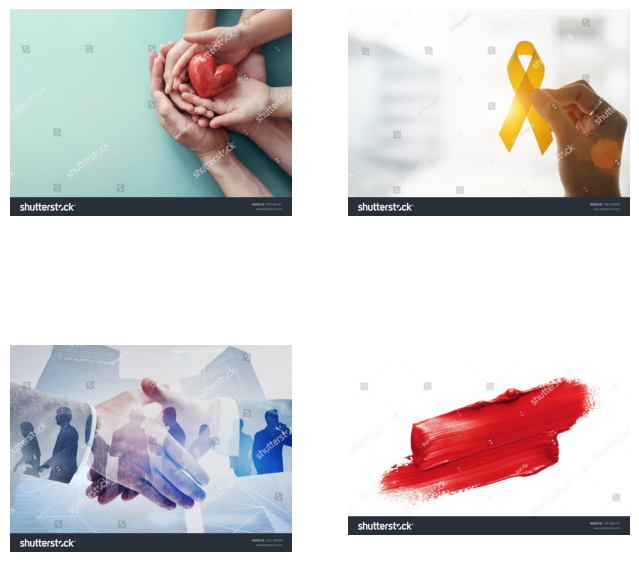

In [9]:
display_images('/kaggle/working/5_images')

Let's plot darker images...

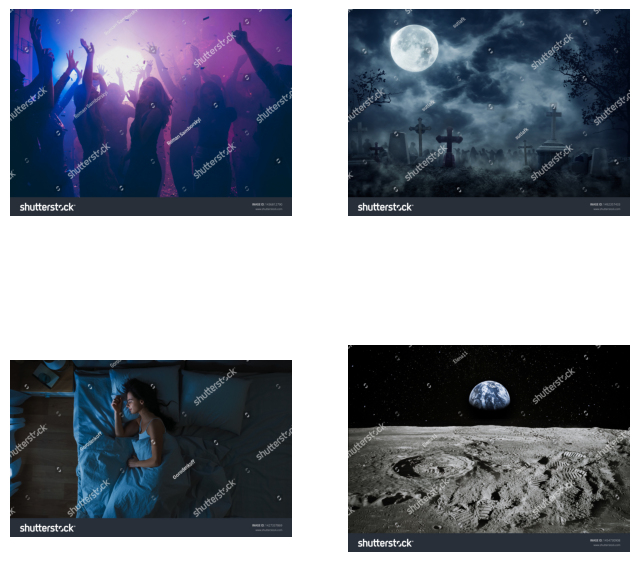

In [10]:
display_images('/kaggle/working/1_images')